In [1]:
import torchvision
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_path = '../data/train/'
test_path = '../data/test/'

In [26]:
# Resize because they have different sizes, flip because the apples will most likely lay down and not stand up

# Use containers

train_transforms = torch.nn.Sequential([
    transforms.CenterCrop(128),
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
    ])

# test_transforms = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
# ])

TypeError: list is not a Module subclass

In [4]:
train_dataset = ImageFolder(root=train_path, transform=train_transforms)
test_dataset = ImageFolder(root=test_path, transform=test_transforms)

print(len(train_dataset))

# Access a specific image and its corresponding label
image, label = train_dataset[0]

# Now, image is a tensor
print(type(image))
print(type(label))

print(image.shape)
# print(image)
print(label)

388
<class 'torch.Tensor'>
<class 'int'>
torch.Size([3, 128, 128])
0


In [5]:
class_names = train_dataset.classes

for idx, class_name in enumerate(class_names):
    print(f"Class {idx}: {class_name}")

Class 0: blotch
Class 1: normal
Class 2: rot
Class 3: scap


In [6]:
def show_imgs(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print("labels: ", labels)

labels:  tensor([3, 2, 2, 3, 0, 3])


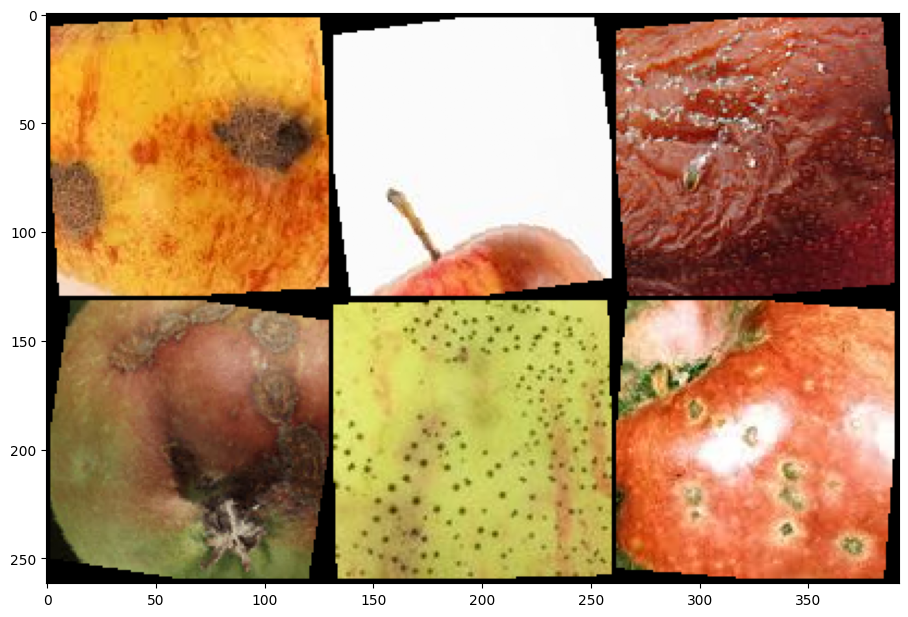

In [7]:
show_imgs(train_dataset)

In [8]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [9]:
print(image)
print(label)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
0


batch sizes with the power of 2 starting from 16 until 1024. This is because the batch size needs to fit the memory requirements of the GPU and the architecture of the CPU.

So, the acceptable values for the batch size are 16, 32, 64, 128, 256, 512 and 1024!

In [10]:
# Minibatches because small dataset
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=False)

In [11]:
np.array(train_loader).shape

()

In [12]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [13]:
def train(model, train_loader, optimizer, n_epochs):
    device = set_device()
    best_acc = 0
    
    history_dict = {}
    
    for epoch in range(n_epochs):
        print("Epoch number %d " % (epoch + 1) )
        
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            predicted_value, predicted_label = torch.max(outputs.data, 1)
            
            loss = nn.CrossEntropyLoss(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct/total
        
        history_dict = {}
        print(" - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))
        
    print("Finished training")
    
            
        
        
        

In [14]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    predicted_correct = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            output = model(images)           
            
            predicted_value, predicted_label = torch.max(output.data, 1)
            
            loss = nn.CrossEntropyLoss(output, labels)
            
            test_loss += loss.item()
            
            predicted_correct += (predicted_label == labels). sum().item()
            
            acc = predicted_correct / total * 100
            
            epoch_loss = test_loss/len(test_loader)
            epoch_acc = 100.00 * predicted_correct/total
            
    print(f" - Prediction time..... predicted correct: {predicted_correct}  out of {total}. ({acc}% accuracy))")
    return f"epoch_acc: {epoch_acc}"
    

            


In [15]:
history = evaluate(model_resnet18_untrained, test_loader) # how to use history.history dataframe to plot. 

NameError: name 'model_resnet18_untrained' is not defined

In [16]:
print(predicted)

NameError: name 'predicted' is not defined

In [17]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

model_resnet18_trained = models.resnet18(pretrained=True)
model_resnet18_untrained = models.resnet18(pretrained=False)

num_ftrs = model_resnet18_untrained.fc.in_features
number_of_classes = 4 
model_resnet18_untrained.fc = nn.Linear(num_ftrs, number_of_classes)

loss_fn = nn.CrossEntropyLoss()  # experiment with different loss functions

optimizer = optim.SGD(model_resnet18_untrained.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

n_epochs = 150


c:\Users\31641\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\31641\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\31641\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings

In [140]:
train(model_resnet18_untrained, train_loader, optimizer, n_epochs=15)

Epoch number 1 


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [138]:
train_model(model_resnet18_trained, train_loader, test_loader, loss_fn, optimizer, n_epochs=15)

Epoch number 1 


KeyboardInterrupt: 

In [41]:
history_resnet18_untrained = evaluate_model(model_resnet18_untrained, test_loader)
history_resnet18_trained = evaluate_model(model_resnet18_trained,)

In [85]:
type(train_dataset)

torchvision.datasets.folder.ImageFolder

In [ ]:
# Custom covnet

my_model_random = nn.Sequential([
    nn.Conv3d(3,6,7),
    nn.AvgPool3d(),
    nn.ConvTranspose3d(),
    nn.MaxUnpool3d(),
    
])



2. How to extract a dict from training and evaluating so I can create a dataframe and plot results?
3. How is trainset[0] different output than image[0]
4. Why normalize tranform?
5. wat bedoelen ze met _, predicted = 


1. forward pass in nn sequential?
